In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


 #  设置一些参数

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'F:/数据科学/2018 DataScience BOWL/stage1_train/'
TEST_PATH = 'F:/数据科学/2018 DataScience BOWL/stage1_test/'

In [4]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

#  Get train and test ids

In [6]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks

In [7]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [8]:
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████| 670/670 [01:44<00:00,  6.40it/s]


# Get and resize test images

In [9]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████████████████████████████████████| 65/65 [00:01<00:00, 33.03it/s]


Done!


# Check if training data looks all right

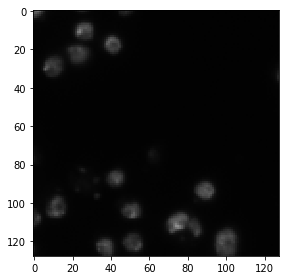

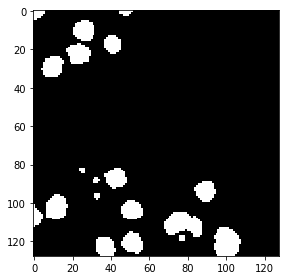

In [10]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Define IoU metric

In [12]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#  Build and train our neural network

# Build U-Net model

In [13]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

# Fit model

In [14]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/30
600/603 [============================>.] - ETA: 2:44 - loss: 0.6679 - mean_iou: 0.0000e+ - ETA: 1:46 - loss: 0.6770 - mean_iou: 0.2039   - ETA: 1:23 - loss: 0.6767 - mean_iou: 0.27 - ETA: 1:14 - loss: 0.6675 - mean_iou: 0.30 - ETA: 1:07 - loss: 0.6662 - mean_iou: 0.33 - ETA: 1:02 - loss: 0.6663 - mean_iou: 0.34 - ETA: 59s - loss: 0.6625 - mean_iou: 0.3551 - ETA: 55s - loss: 0.6593 - mean_iou: 0.362 - ETA: 53s - loss: 0.6550 - mean_iou: 0.368 - ETA: 51s - loss: 0.6444 - mean_iou: 0.373 - ETA: 49s - loss: 0.6387 - mean_iou: 0.377 - ETA: 48s - loss: 0.6565 - mean_iou: 0.380 - ETA: 46s - loss: 0.6452 - mean_iou: 0.383 - ETA: 45s - loss: 0.6327 - mean_iou: 0.385 - ETA: 44s - loss: 0.6283 - mean_iou: 0.388 - ETA: 43s - loss: 0.6228 - mean_iou: 0.390 - ETA: 42s - loss: 0.6142 - mean_iou: 0.391 - ETA: 41s - loss: 0.6100 - mean_iou: 0.393 - ETA: 40s - loss: 0.6040 - mean_iou: 0.394 - ETA: 39s - loss: 0.5994 - mean_iou: 0.396 - ETA: 38s - l

600/603 [============================>.] - ETA: 50s - loss: 0.2257 - mean_iou: 0.423 - ETA: 49s - loss: 0.2449 - mean_iou: 0.423 - ETA: 48s - loss: 0.2471 - mean_iou: 0.423 - ETA: 47s - loss: 0.2522 - mean_iou: 0.423 - ETA: 45s - loss: 0.2417 - mean_iou: 0.423 - ETA: 44s - loss: 0.2209 - mean_iou: 0.423 - ETA: 43s - loss: 0.2250 - mean_iou: 0.423 - ETA: 43s - loss: 0.2247 - mean_iou: 0.423 - ETA: 42s - loss: 0.2274 - mean_iou: 0.423 - ETA: 41s - loss: 0.2305 - mean_iou: 0.423 - ETA: 40s - loss: 0.2306 - mean_iou: 0.423 - ETA: 40s - loss: 0.2304 - mean_iou: 0.423 - ETA: 39s - loss: 0.2275 - mean_iou: 0.423 - ETA: 38s - loss: 0.2349 - mean_iou: 0.423 - ETA: 38s - loss: 0.2346 - mean_iou: 0.423 - ETA: 37s - loss: 0.2298 - mean_iou: 0.423 - ETA: 37s - loss: 0.2280 - mean_iou: 0.423 - ETA: 36s - loss: 0.2259 - mean_iou: 0.423 - ETA: 35s - loss: 0.2259 - mean_iou: 0.423 - ETA: 34s - loss: 0.2231 - mean_iou: 0.423 - ETA: 34s - loss: 0.2257 - mean_iou: 0.423 - ETA: 33s - loss: 0.2299 - mean_io

600/603 [============================>.] - ETA: 45s - loss: 0.1228 - mean_iou: 0.435 - ETA: 45s - loss: 0.1745 - mean_iou: 0.435 - ETA: 45s - loss: 0.1824 - mean_iou: 0.435 - ETA: 45s - loss: 0.1805 - mean_iou: 0.435 - ETA: 44s - loss: 0.1857 - mean_iou: 0.435 - ETA: 44s - loss: 0.1752 - mean_iou: 0.435 - ETA: 44s - loss: 0.1747 - mean_iou: 0.435 - ETA: 43s - loss: 0.1770 - mean_iou: 0.435 - ETA: 42s - loss: 0.1757 - mean_iou: 0.435 - ETA: 42s - loss: 0.1734 - mean_iou: 0.435 - ETA: 41s - loss: 0.1730 - mean_iou: 0.435 - ETA: 40s - loss: 0.1658 - mean_iou: 0.435 - ETA: 39s - loss: 0.1744 - mean_iou: 0.435 - ETA: 39s - loss: 0.1752 - mean_iou: 0.435 - ETA: 38s - loss: 0.1748 - mean_iou: 0.435 - ETA: 37s - loss: 0.1740 - mean_iou: 0.435 - ETA: 36s - loss: 0.1701 - mean_iou: 0.435 - ETA: 36s - loss: 0.1708 - mean_iou: 0.435 - ETA: 35s - loss: 0.1693 - mean_iou: 0.435 - ETA: 34s - loss: 0.1688 - mean_iou: 0.435 - ETA: 34s - loss: 0.1682 - mean_iou: 0.435 - ETA: 33s - loss: 0.1665 - mean_io

600/603 [============================>.] - ETA: 43s - loss: 0.1003 - mean_iou: 0.491 - ETA: 44s - loss: 0.1023 - mean_iou: 0.491 - ETA: 44s - loss: 0.1005 - mean_iou: 0.492 - ETA: 44s - loss: 0.0980 - mean_iou: 0.492 - ETA: 43s - loss: 0.1042 - mean_iou: 0.492 - ETA: 42s - loss: 0.1025 - mean_iou: 0.493 - ETA: 42s - loss: 0.0976 - mean_iou: 0.493 - ETA: 41s - loss: 0.0998 - mean_iou: 0.493 - ETA: 40s - loss: 0.0961 - mean_iou: 0.494 - ETA: 40s - loss: 0.0960 - mean_iou: 0.494 - ETA: 39s - loss: 0.0953 - mean_iou: 0.494 - ETA: 38s - loss: 0.0928 - mean_iou: 0.494 - ETA: 38s - loss: 0.0921 - mean_iou: 0.495 - ETA: 37s - loss: 0.0916 - mean_iou: 0.495 - ETA: 37s - loss: 0.0919 - mean_iou: 0.495 - ETA: 36s - loss: 0.0939 - mean_iou: 0.495 - ETA: 35s - loss: 0.0944 - mean_iou: 0.496 - ETA: 35s - loss: 0.0969 - mean_iou: 0.496 - ETA: 34s - loss: 0.1005 - mean_iou: 0.496 - ETA: 33s - loss: 0.1011 - mean_iou: 0.496 - ETA: 33s - loss: 0.0997 - mean_iou: 0.497 - ETA: 32s - loss: 0.1002 - mean_io

600/603 [============================>.] - ETA: 42s - loss: 0.0675 - mean_iou: 0.565 - ETA: 43s - loss: 0.0680 - mean_iou: 0.566 - ETA: 42s - loss: 0.0843 - mean_iou: 0.566 - ETA: 42s - loss: 0.0902 - mean_iou: 0.566 - ETA: 42s - loss: 0.0818 - mean_iou: 0.566 - ETA: 41s - loss: 0.1028 - mean_iou: 0.566 - ETA: 41s - loss: 0.0957 - mean_iou: 0.567 - ETA: 40s - loss: 0.0968 - mean_iou: 0.567 - ETA: 40s - loss: 0.0945 - mean_iou: 0.567 - ETA: 39s - loss: 0.0931 - mean_iou: 0.567 - ETA: 39s - loss: 0.0918 - mean_iou: 0.567 - ETA: 38s - loss: 0.0880 - mean_iou: 0.567 - ETA: 38s - loss: 0.0856 - mean_iou: 0.568 - ETA: 37s - loss: 0.0853 - mean_iou: 0.568 - ETA: 37s - loss: 0.0878 - mean_iou: 0.568 - ETA: 36s - loss: 0.0910 - mean_iou: 0.568 - ETA: 35s - loss: 0.0902 - mean_iou: 0.568 - ETA: 35s - loss: 0.0890 - mean_iou: 0.569 - ETA: 34s - loss: 0.0893 - mean_iou: 0.569 - ETA: 34s - loss: 0.0888 - mean_iou: 0.569 - ETA: 33s - loss: 0.0878 - mean_iou: 0.569 - ETA: 32s - loss: 0.0895 - mean_io

600/603 [============================>.] - ETA: 46s - loss: 0.0887 - mean_iou: 0.616 - ETA: 45s - loss: 0.0910 - mean_iou: 0.616 - ETA: 44s - loss: 0.0770 - mean_iou: 0.616 - ETA: 44s - loss: 0.0791 - mean_iou: 0.616 - ETA: 43s - loss: 0.0880 - mean_iou: 0.616 - ETA: 42s - loss: 0.0845 - mean_iou: 0.617 - ETA: 41s - loss: 0.0810 - mean_iou: 0.617 - ETA: 41s - loss: 0.0769 - mean_iou: 0.617 - ETA: 40s - loss: 0.0738 - mean_iou: 0.617 - ETA: 39s - loss: 0.0790 - mean_iou: 0.617 - ETA: 39s - loss: 0.0796 - mean_iou: 0.617 - ETA: 38s - loss: 0.0799 - mean_iou: 0.617 - ETA: 37s - loss: 0.0829 - mean_iou: 0.617 - ETA: 37s - loss: 0.0844 - mean_iou: 0.617 - ETA: 36s - loss: 0.0845 - mean_iou: 0.618 - ETA: 35s - loss: 0.0857 - mean_iou: 0.618 - ETA: 35s - loss: 0.0836 - mean_iou: 0.618 - ETA: 34s - loss: 0.0844 - mean_iou: 0.618 - ETA: 34s - loss: 0.0836 - mean_iou: 0.618 - ETA: 33s - loss: 0.0834 - mean_iou: 0.618 - ETA: 32s - loss: 0.0860 - mean_iou: 0.618 - ETA: 32s - loss: 0.0880 - mean_io

600/603 [============================>.] - ETA: 46s - loss: 0.0440 - mean_iou: 0.650 - ETA: 46s - loss: 0.0577 - mean_iou: 0.651 - ETA: 45s - loss: 0.0652 - mean_iou: 0.651 - ETA: 44s - loss: 0.0752 - mean_iou: 0.651 - ETA: 43s - loss: 0.0695 - mean_iou: 0.651 - ETA: 43s - loss: 0.0762 - mean_iou: 0.651 - ETA: 42s - loss: 0.0803 - mean_iou: 0.651 - ETA: 42s - loss: 0.0847 - mean_iou: 0.651 - ETA: 41s - loss: 0.0833 - mean_iou: 0.651 - ETA: 41s - loss: 0.0803 - mean_iou: 0.651 - ETA: 40s - loss: 0.0756 - mean_iou: 0.651 - ETA: 39s - loss: 0.0796 - mean_iou: 0.651 - ETA: 38s - loss: 0.0784 - mean_iou: 0.651 - ETA: 38s - loss: 0.0837 - mean_iou: 0.651 - ETA: 37s - loss: 0.0846 - mean_iou: 0.652 - ETA: 36s - loss: 0.0844 - mean_iou: 0.652 - ETA: 36s - loss: 0.0871 - mean_iou: 0.652 - ETA: 35s - loss: 0.0859 - mean_iou: 0.652 - ETA: 34s - loss: 0.0878 - mean_iou: 0.652 - ETA: 34s - loss: 0.0860 - mean_iou: 0.652 - ETA: 33s - loss: 0.0879 - mean_iou: 0.652 - ETA: 33s - loss: 0.0894 - mean_io

600/603 [============================>.] - ETA: 45s - loss: 0.1130 - mean_iou: 0.677 - ETA: 44s - loss: 0.1301 - mean_iou: 0.677 - ETA: 43s - loss: 0.1090 - mean_iou: 0.677 - ETA: 43s - loss: 0.1204 - mean_iou: 0.677 - ETA: 42s - loss: 0.1077 - mean_iou: 0.677 - ETA: 41s - loss: 0.1013 - mean_iou: 0.677 - ETA: 41s - loss: 0.0948 - mean_iou: 0.677 - ETA: 40s - loss: 0.1005 - mean_iou: 0.677 - ETA: 40s - loss: 0.0914 - mean_iou: 0.677 - ETA: 39s - loss: 0.0864 - mean_iou: 0.677 - ETA: 39s - loss: 0.0853 - mean_iou: 0.677 - ETA: 38s - loss: 0.0879 - mean_iou: 0.677 - ETA: 38s - loss: 0.0878 - mean_iou: 0.677 - ETA: 37s - loss: 0.0864 - mean_iou: 0.677 - ETA: 36s - loss: 0.0878 - mean_iou: 0.677 - ETA: 36s - loss: 0.0889 - mean_iou: 0.677 - ETA: 35s - loss: 0.0875 - mean_iou: 0.677 - ETA: 35s - loss: 0.0863 - mean_iou: 0.678 - ETA: 34s - loss: 0.0883 - mean_iou: 0.678 - ETA: 33s - loss: 0.0880 - mean_iou: 0.678 - ETA: 33s - loss: 0.0868 - mean_iou: 0.678 - ETA: 32s - loss: 0.0856 - mean_io

600/603 [============================>.] - ETA: 45s - loss: 0.0757 - mean_iou: 0.696 - ETA: 44s - loss: 0.0858 - mean_iou: 0.696 - ETA: 44s - loss: 0.0810 - mean_iou: 0.696 - ETA: 44s - loss: 0.0901 - mean_iou: 0.696 - ETA: 43s - loss: 0.0797 - mean_iou: 0.696 - ETA: 43s - loss: 0.0771 - mean_iou: 0.697 - ETA: 42s - loss: 0.0723 - mean_iou: 0.697 - ETA: 42s - loss: 0.0736 - mean_iou: 0.697 - ETA: 41s - loss: 0.0741 - mean_iou: 0.697 - ETA: 40s - loss: 0.0727 - mean_iou: 0.697 - ETA: 40s - loss: 0.0774 - mean_iou: 0.697 - ETA: 39s - loss: 0.0766 - mean_iou: 0.697 - ETA: 38s - loss: 0.0757 - mean_iou: 0.697 - ETA: 37s - loss: 0.0764 - mean_iou: 0.697 - ETA: 37s - loss: 0.0784 - mean_iou: 0.697 - ETA: 36s - loss: 0.0776 - mean_iou: 0.697 - ETA: 36s - loss: 0.0843 - mean_iou: 0.697 - ETA: 35s - loss: 0.0858 - mean_iou: 0.697 - ETA: 35s - loss: 0.0870 - mean_iou: 0.697 - ETA: 34s - loss: 0.0848 - mean_iou: 0.697 - ETA: 33s - loss: 0.0821 - mean_iou: 0.697 - ETA: 33s - loss: 0.0814 - mean_io

# Make predictions

In [15]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 2s 25ms/step


# Perform a sanity check on some random training samples

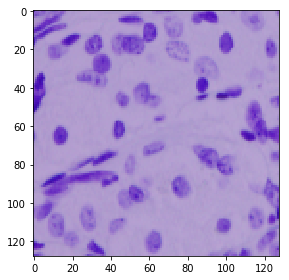

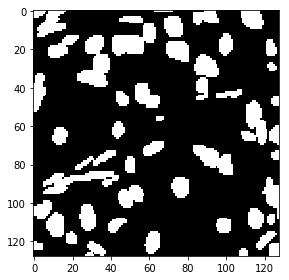

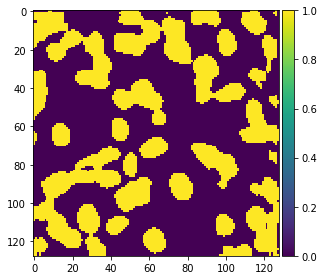

In [16]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Encode and submit our results

In [18]:
# Perform a sanity check on some random validation samples
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [19]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [20]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)